# Problem 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.stats as sts

inc = np.loadtxt('usincmoms.txt', delimiter = '\t')

## 1(a)

In [2]:
midpt0 = 2.025e+05
midpt = []
while midpt0 < 350000:
    midpt.append(midpt0)
    midpt0 += 5000

midpt = np.array(midpt)
height = np.append(np.repeat(inc[40,0]/10,10),np.repeat(inc[41,0]/20,20))

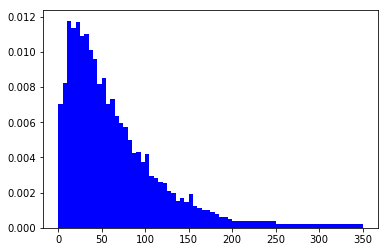

In [3]:
plt.bar(inc[0:40,1]/1000, inc[0:40,0]/5, width = 5, align = 'center', color = 'b')
plt.bar(midpt/1000, height/5, width = 5, align = 'center', color = 'b')
plt.show()

## 1(b)

In [4]:
lower = np.append(inc[0:40,1]/1000-2.5, [inc[40,1]/1000-25, inc[41,1]/1000-50])
upper = np.append(inc[0:40,1]/1000+2.5, [inc[40,1]/1000+25, inc[41,1]/1000+50])

def model_mom(mu,sig):
    prob_up = sts.lognorm.cdf(upper, sig, scale = np.exp(mu))
    prob_low = sts.lognorm.cdf(lower, sig, scale = np.exp(mu))
    return prob_up - prob_low

def err_vec(xvals, mu, sig):
    mom_data = xvals[:,0]
    mom_model = model_mom(mu,sig)
    err_vec = mom_data - mom_model
    return err_vec

def crit(params, *args):
    mu, sig = params
    xvals, W = args
    err = err_vec(xvals, mu, sig)
    crit_val = err.T @ W @ err
    return crit_val

In [5]:
mu_init = np.log(inc.mean())
sig_init = np.log(inc.std())
params_init = np.array([mu_init, sig_init])
W = np.diag(inc[:,0])
gmm_args = (inc, W)

result = opt.minimize(crit, params_init, args = (gmm_args), method = 'L-BFGS-B', bounds = ((None,None),(1e-10,None)))
mu_gmm, sig_gmm = result.x
print(result)

      fun: 3.5230053580978087e-05
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.98224480e-06,  -2.56828521e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 105
      nit: 16
   status: 0
  success: True
        x: array([ 3.95372274,  1.02271787])


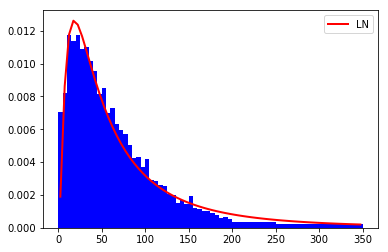

In [6]:
pts = np.append(inc[0:40,1]/1000, midpt/1000) # np.linspace(0, 350, 500)
plt.bar(inc[0:40,1]/1000, inc[0:40,0]/5, width = 5, align = 'center', color = 'b')
plt.bar(midpt/1000, height/5, width = 5, align = 'center', color = 'b')
plt.plot(pts, sts.lognorm.pdf(pts, sig_gmm, scale = np.exp(mu_gmm)), color = 'r', linewidth = 2, label = 'LN')
plt.legend(loc = 'upper right')
plt.show()

## 1(c)

In [7]:
def model_mom_ga(alpha,beta):
    prob_up = sts.gamma.cdf(upper, alpha, scale = beta)
    prob_low = sts.gamma.cdf(lower, alpha, scale = beta)
    return prob_up - prob_low

def err_vec_ga(xvals, alpha, beta):
    mom_data = xvals[:,0]
    mom_model = model_mom_ga(alpha,beta)
    err_vec = mom_data - mom_model
    return err_vec

def crit_ga(params, *args):
    alpha, beta = params
    xvals, W = args
    err = err_vec_ga(xvals, alpha, beta)
    crit_val = err.T @ W @ err
    return crit_val

In [8]:
alpha_init = 3
beta_init = 20
params_init_ga = np.array([alpha_init, beta_init])

result_ga = opt.minimize(crit_ga, params_init_ga, args = (gmm_args), method = 'L-BFGS-B', bounds = ((1e-10,None),(1e-10,None)))
alpha_gmm, beta_gmm = result_ga.x
print(result_ga)

      fun: 1.4963451855983452e-05
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -9.70201872e-07,  -1.62875000e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 48
      nit: 14
   status: 0
  success: True
        x: array([  1.50443453,  41.14947095])


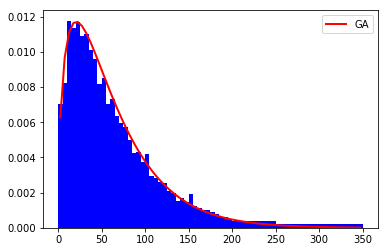

In [9]:
plt.bar(inc[0:40,1]/1000, inc[0:40,0]/5, width = 5, align = 'center', color = 'b')
plt.bar(midpt/1000, height/5, width = 5, align = 'center', color = 'b')
plt.plot(pts, sts.gamma.pdf(pts, alpha_gmm, scale = beta_gmm), color = 'r', linewidth = 2, label = 'GA')
plt.legend(loc = 'upper right')
plt.show()

## 1(d)

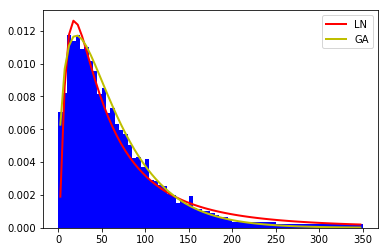

In [10]:
plt.bar(inc[0:40,1]/1000, inc[0:40,0]/5, width = 5, align = 'center', color = 'b')
plt.bar(midpt/1000, height/5, width = 5, align = 'center', color = 'b')
plt.plot(pts, sts.lognorm.pdf(pts, sig_gmm, scale = np.exp(mu_gmm)), color = 'r', label = 'LN', linewidth = 2)
plt.plot(pts, sts.gamma.pdf(pts, alpha_gmm, scale = beta_gmm), color = 'y', label = 'GA', linewidth = 2)
plt.legend(loc = 'upper right')
plt.show()

### We could compare the minimized objective of (b) and (c), since they both use the same weight matrix. It shows that Gamma distribution fits better.

In [11]:
obj_val_ln = result.fun
obj_val_ga = result_ga.fun
print('Minimized Lognormal Objective =', obj_val_ln)
print('Minimized Gamma Objective =', obj_val_ga)

Minimized Lognormal Objective = 3.5230053581e-05
Minimized Gamma Objective = 1.4963451856e-05


## 1(e)

In [12]:
result_first = opt.minimize(crit_ga, params_init_ga, args = (inc, np.identity(inc.shape[0])), method = 'L-BFGS-B', bounds = ((1e-10,None),(1e-10,None)))
alpha_first, beta_first = result_first.x
print(result_first)
err_vec_first = np.reshape(err_vec_ga(inc, alpha_first, beta_first),(42,1))
omega = (err_vec_first @ err_vec_first.T) / inc.shape[0] 
W_2step = np.linalg.pinv(omega)

params_init_2step = np.array([alpha_first, beta_first])
result_2step = opt.minimize(crit_ga, params_init_2step, args = (inc, W_2step), method = 'L-BFGS-B', bounds = ((1e-10,None),(1e-10,None)), tol = 1e-10)
alpha_2step, beta_2step = result_2step.x
print(result_2step)

      fun: 0.00035229456275127533
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  2.27302985e-08,  -1.73472348e-10])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 63
      nit: 16
   status: 0
  success: True
        x: array([  1.37654289,  48.06672308])
      fun: 41.999999974308444
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.93978167e-04,  -7.46069873e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 12
      nit: 2
   status: 0
  success: True
        x: array([  1.37652321,  48.06672421])


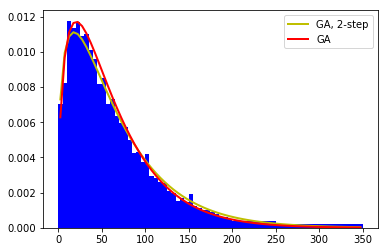

In [13]:
plt.bar(inc[0:40,1]/1000, inc[0:40,0]/5, width = 5, align = 'center', color = 'b')
plt.bar(midpt/1000, height/5, width = 5, align = 'center', color = 'b')
plt.plot(pts, sts.gamma.pdf(pts, alpha_2step, scale = beta_2step), color = 'y', label = 'GA, 2-step', linewidth = 2)
plt.plot(pts, sts.gamma.pdf(pts, alpha_gmm, scale = beta_gmm), color = 'r', label = 'GA', linewidth = 2)
plt.legend(loc = 'upper right')
plt.show()

### We could not compare the results of (c) and (e) based on the minimized criterion value because the weight matrix is different in two cases. Although the estimates change, they do not deviate much from the original results.

# Problem 2

In [14]:
bm = np.loadtxt('MacroSeries.txt', delimiter = ',')

In [15]:
def z_backout(alpha, xvals):
    z = np.log(xvals[:,3]/(alpha*xvals[:,1]**(alpha-1)))
    return z

def data_mom_bm(alpha, beta, rho, mu, xvals):
    z = z_backout(alpha, xvals)
    z_t = z[1:100]
    z_t_1 = z[0:99]
    k_t = xvals[:,1][1:100]
    c_t = xvals[:,0][1:100]
    c_t_1 = xvals[:,0][0:99]
    w_t_1 = xvals[:,2][0:99]
    mom1 = (z_t - rho*z_t_1 - (1-rho)*mu).mean()
    mom2 = ((z_t - rho*z_t_1 - (1-rho)*mu)*z_t).mean()
    mom3 = (beta*alpha*np.exp(z_t)*k_t**(alpha-1)*c_t/c_t_1 - 1).mean()
    mom4 = ((beta*alpha*np.exp(z_t)*k_t**(alpha-1)*c_t/c_t_1 - 1)*w_t_1).mean()    
    return mom1, mom2, mom3, mom4

def err_vec_bm(alpha, beta, rho, mu, xvals):
    mom1, mom2, mom3, mom4 = data_mom_bm(alpha, beta, rho, mu, xvals)
    err_vec = np.array([mom1, mom2, mom3, mom4])
    return err_vec.T

def crit_bm(params, args):
    alpha, beta, rho, mu = params
    xvals = args
    W = np.eye(4)
    err = err_vec_bm(alpha, beta, rho, mu, xvals)
    crit_val = err.T @ W @ err
    return crit_val

In [16]:
alpha0 = 0.31
beta0 = 0.9
rho0 = 0.9
mu0 = 9.5
params0 = np.array([alpha0, beta0, rho0, mu0])
bdns = ((1e-10, 1-1e-10),(1e-10, 1-1e-10),(-1+1e-10, 1-1e-10),(1e-10, None))

result_bm = opt.minimize(crit_bm, params0, args = bm, method = 'L-BFGS-B', bounds = bdns)
alpha_bm, beta_bm, rho_bm, mu_bm = result_bm.x
print(result_bm)

      fun: 0.0010930774909079565
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -4.86678672e-02,   4.66191998e+05,   3.62744773e-03,
        -3.11632582e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 245
      nit: 37
   status: 0
  success: True
        x: array([ 0.4525253 ,  0.97404718,  0.96239994,  9.50089856])


In [17]:
print('alpha GMM =', alpha_bm)
print('beta GMM =', beta_bm)
print('rho GMM =', rho_bm)
print('mu GMM =', mu_bm)
print('minimized criterion function =', result_bm.fun)

alpha GMM = 0.452525303981
beta GMM = 0.974047183607
rho GMM = 0.962399940652
mu GMM = 9.50089856056
minimized criterion function = 0.00109307749091


### After estimating using a wide range of initial values, the one displayed above gives the minimized criterion value.